# 

In [2]:
import requests
import zipfile
from pathlib import Path

In [4]:
data_path = Path("data")
image_path = data_path/"pizza_steak_sushi"


with open(data_path/"pizza_steak_sushi.zip", 'wb') as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    f.write(request.content)

with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", 'r') as zip_ref:
    zip_ref.extractall(image_path)

In [5]:
train_dir = image_path/"train"
test_dir = image_path/"test"

train_dir

PosixPath('data/pizza_steak_sushi/train')

In [6]:
from PIL import Image
import random
import os

random.seed(42)
image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)
(random_image_path)

PosixPath('data/pizza_steak_sushi/train/pizza/2026009.jpg')

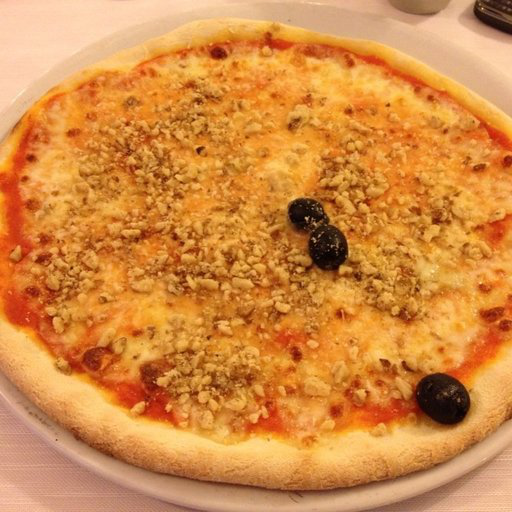

In [7]:
img = Image.open(random_image_path)
img

In [8]:
image_class = random_image_path.parent.stem
image_class

'pizza'

In [9]:
img.height, img.width

(512, 512)

In [10]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)
img_as_array.shape


(512, 512, 3)

(-0.5, 511.5, 511.5, -0.5)

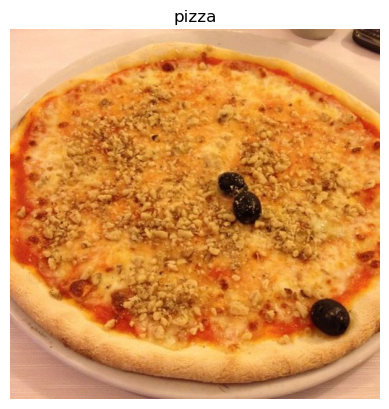

In [11]:
plt.imshow(img_as_array)
plt.title(image_class)
plt.axis(False)

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
import torchvision.datasets as datasets

In [13]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [14]:
data_transform(img).shape

torch.Size([3, 64, 64])

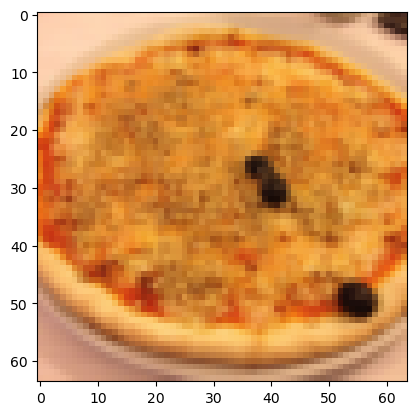

In [15]:
plt.imshow(data_transform(img).permute(1, 2, 0))

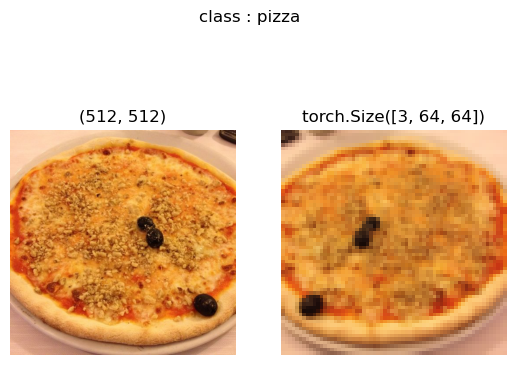

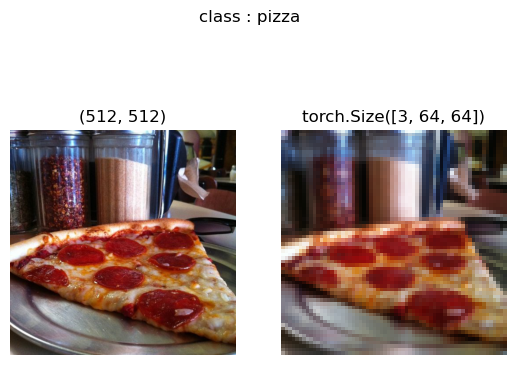

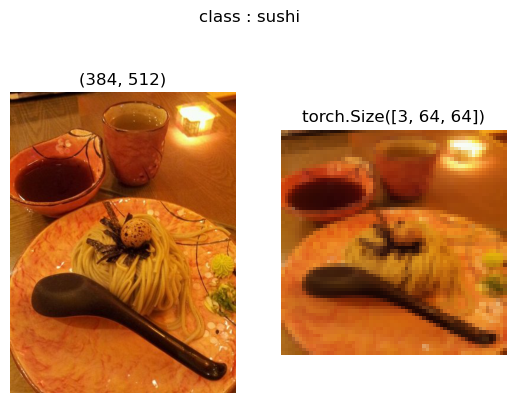

In [17]:
def plot_tranformed_images(image_path, transform, n=3, seed=None):
    if seed:
        random.seed(seed)
    for image_path in random.sample(image_path, k=n):
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f.size)
            ax[0].axis(False)

            transformed_image = transform(f)
            ax[1].imshow(transformed_image.permute(1, 2, 0)) #the number mean index, this permute is going to switch index 0 -> 3, 1 -> 0, 2->1
            #this is important to know, the "resize(w, h, c)" ins't same as permute you'll see this when you show images on matlotlib, you can try
            ax[1].set_title(transformed_image.shape)
            ax[1].axis(False)

            fig.suptitle(f"class : {image_path.parent.stem}")

plot_tranformed_images(image_path_list, data_transform, n=3, seed=42)
    

In [23]:
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform, target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform, target_transform=None)

In [26]:
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [27]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [319]:
batch_size = 15
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=4)
test_dataloader = DataLoader(test_data, shuffle=False, batch_size=batch_size, num_workers=1)

img, label = next(iter(train_dataloader))
img.shape
#####################################################

torch.Size([15, 3, 64, 64])

In [29]:
#harder part (which is like we're coding the backward of ImageFolder in pytorch)
target_directory = train_dir

def find_classname(directoryPath):
    try :
        class_names_found = sorted([entry.name for entry in list(os.scandir(directoryPath))])
        class_to_idx = {class_name : i for i, class_name in enumerate(class_names_found)}

    except :
        if not class_names_found:
            raise FileNotFoundError("bro what? there's no mf this path")
    return class_names_found, class_to_idx

In [30]:
class_name, class_idx = find_classname(train_dir)
class_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [295]:
from torch.utils.data import Dataset
import pathlib
#combine it all

class ImageFolderCustom(Dataset):
    def __init__(self, path, transform=None):
        self.path = list(pathlib.Path(path).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = find_classname(path)

    def load_image(self, index):
        image_path = self.path[index]
        return Image.open(image_path)

    def __len__(self):
        return len(self.path)

    def __getitem__(self, index): #this is like we code "img, label = data[index]"
        img = self.load_image(index)
        class_name = self.path[index].parent.name
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img), class_idx
        return img, class_idx

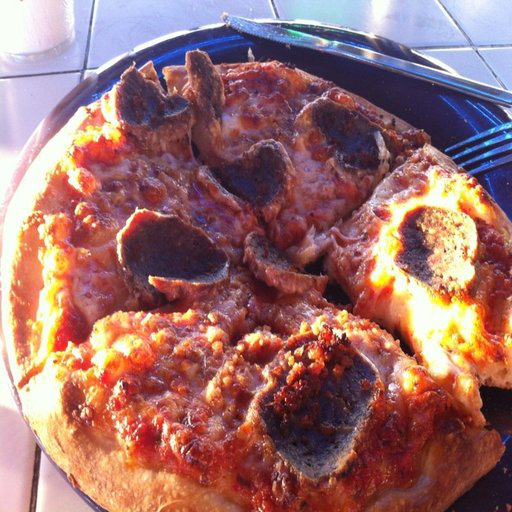

In [297]:
train_data_custom = ImageFolderCustom(path=train_dir, transform=data_transform)
test_data_custom = ImageFolderCustom(path=test_dir, transform=data_transform)
train_data_custom.load_image(0)

In [299]:
len(train_data_custom), train_data_custom.classes, train_data_custom.class_to_idx, train_data_custom.transform

(225,
 ['pizza', 'steak', 'sushi'],
 {'pizza': 0, 'steak': 1, 'sushi': 2},
 Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
     RandomHorizontalFlip(p=0.5)
     ToTensor()
 ))

In [301]:
train_data_custom.classes == train_data.classes

True

In [303]:
def displayrandomImages(dataset, classes, n=5, display_shape=True, seed=None):
    title = ""
    if n>10:
        print('limit is 10')
        n = 10

    if seed:
        random.seed(seed)

    random_idx = random.sample(range(len(dataset)), k=n)
    plt.figure(figsize=(16, 16))

    for i, targ_sample in enumerate(random_idx):
        targ_img, targ_label = dataset[targ_sample][0].permute(1, 2, 0), dataset[targ_sample][1]
        if i <= 4:
            plt.subplot(1, 5, i+1)
        if i >= 5:
            plt.subplot(2, 5, i+1)
        plt.imshow(targ_img)
        plt.axis(False)
        if classes:
            title = f"Class : {classes[targ_label]}"
        if display_shape:
            title = title + f"\nshape: {list(targ_img.shape)}"
        plt.title(title)
    

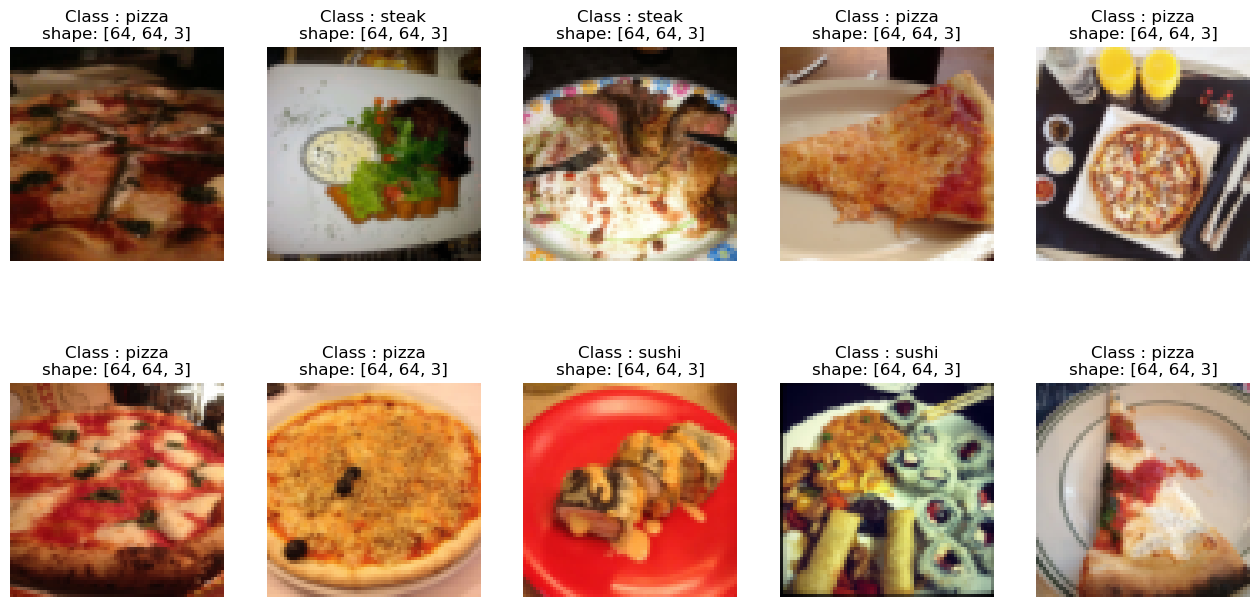

In [305]:
displayrandomImages(train_data, n=10, classes=class_names)

In [306]:
train_dataloader_custom = DataLoader(train_data_custom, batch_size=batch_size, num_workers=4, shuffle=True)
test_dataloader_custom = DataLoader(test_data_custom, batch_size=batch_size, num_workers=2, shuffle=False)

In [309]:
train_dataloader_custom

In [311]:
img_custom, label_custom = next(iter(train_dataloader_custom))

In [315]:
img_custom.shape

torch.Size([15, 3, 64, 64])

Data augmentation
- what is data augmentation? it's reusing old data but change somethin' like, change color, rotate it

In [337]:
from torchvision import transforms
#this is an example of augmentation

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(31),
    transforms.ToTensor() 
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

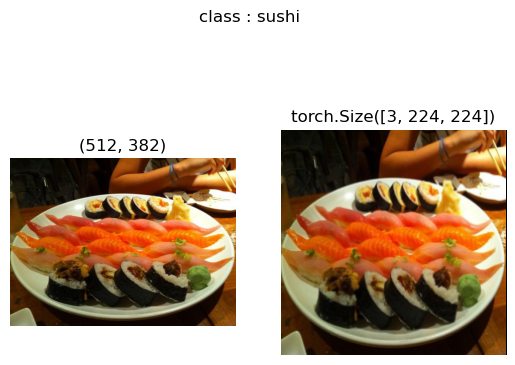

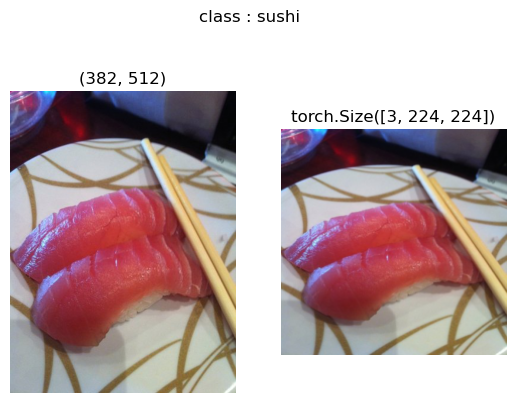

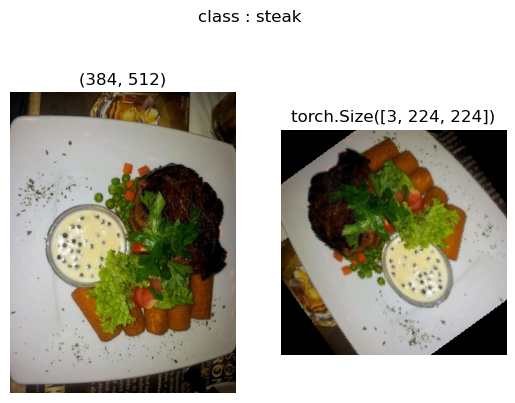

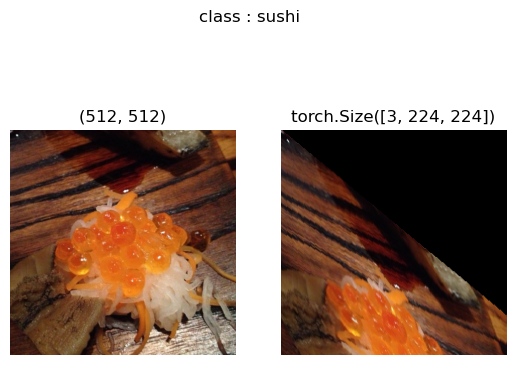

In [346]:
plot_tranformed_images(image_path_list, transform=train_transform, n=4)